In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

100%|██████████| 50/50 [03:41<00:00,  4.43s/it]

cmb0F_1 (500, 800, 401)
kCmbF_1 (500, 800, 401)
lCmbF_1 (500, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (500, 800, 401)
noiseF_1 (500, 800, 401)
totalF_1 (500, 800, 401)
totalF_0 (500, 800, 401)


In [6]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [7]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [8]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

CMB experiment properties


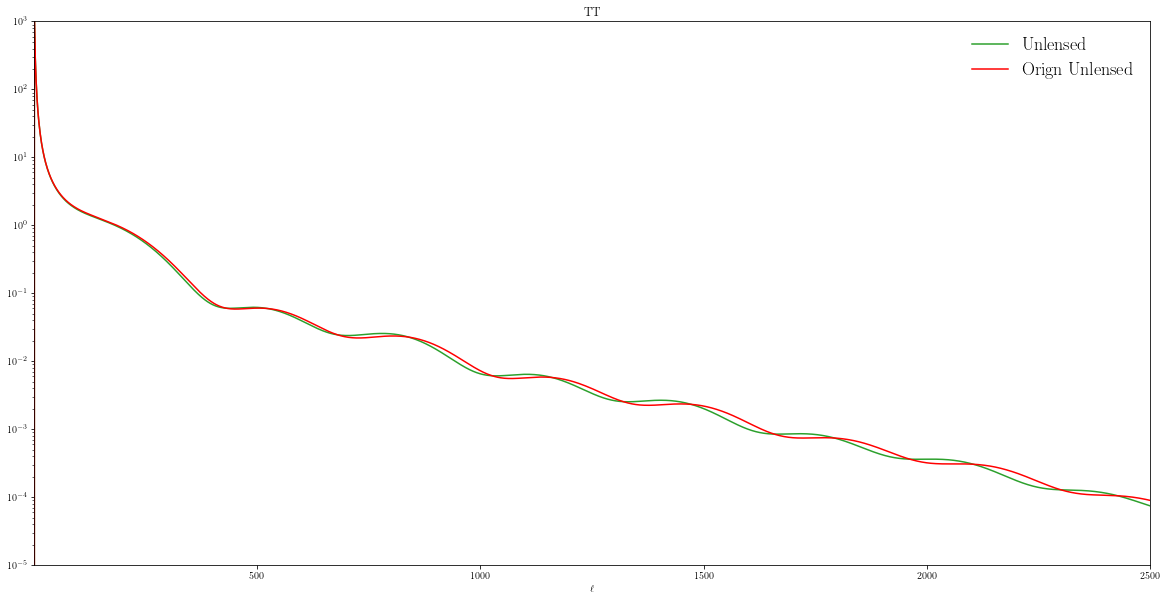

In [9]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(20,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
# plt.scatter(ls,totCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='k', s=5, label='Lensed')

plt.plot(ls,unlensedCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='C2', label='Unlensed')
plt.plot(ls,origTT, color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([2,2500])
plt.ylim([1e-5, 1e3])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('log')

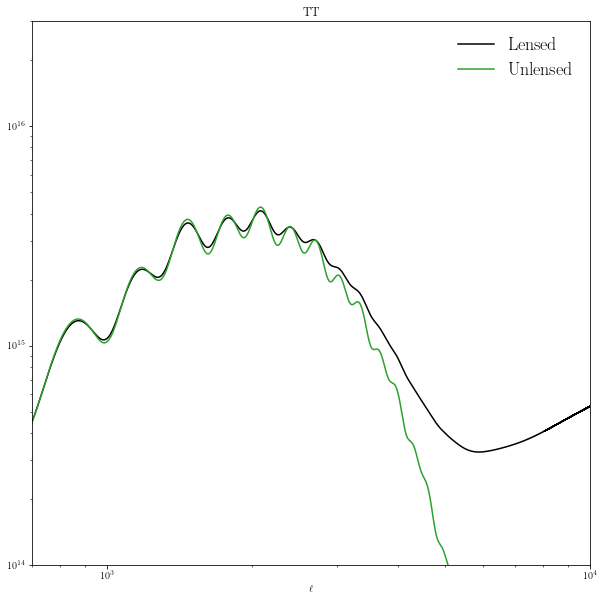

In [30]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(10,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
plt.plot(ls,totCL[:,0]*ls**4, color='k', label='Lensed')

plt.plot(ls,unlensedCL[:,0]*ls**4, color='C2', label='Unlensed')
# plt.plot(ls,origTT, color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([700,10000])
plt.ylim([1e14, 3e16])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('log')
plt.xscale('log')

In [10]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


(2, 30000)

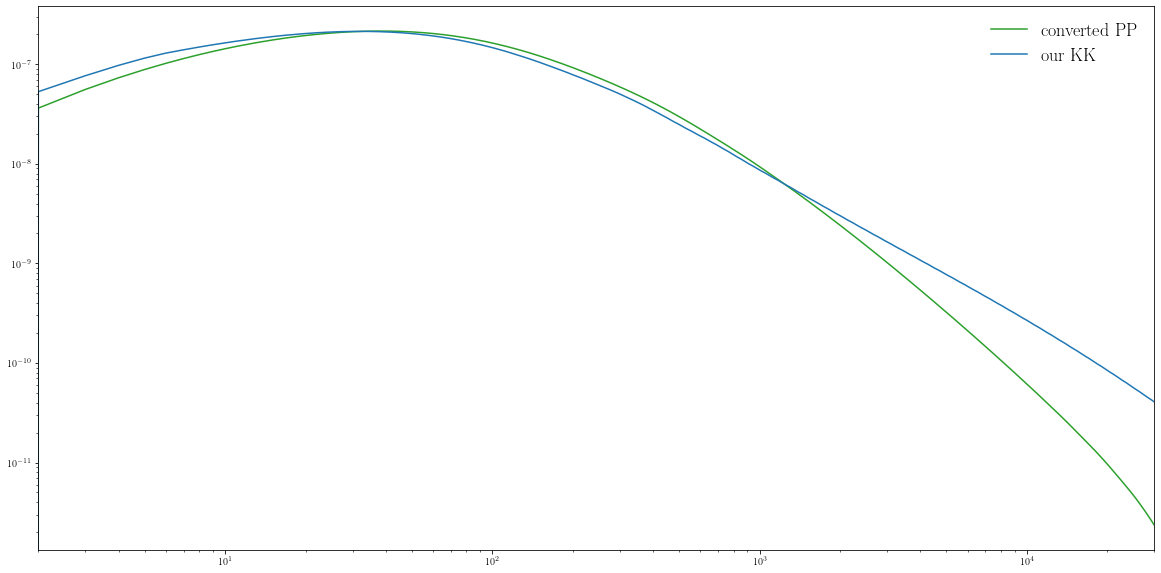

In [31]:
ls = np.arange(cl.shape[0])
plt.figure(figsize=(20,10))
PP = cl[:,0]
rawPP = PP*2*np.pi/((ls*(ls+1))**2)
rawKK = ls**4/4 * rawPP

plt.plot(ls, rawKK, color='C2', label='converted PP')

kk_ours = np.array(list(map(p2d_cmblens.fPinterp, ls)))

# plt.plot(ls, kk_ours*(ls*(ls+1))**2/(2*np.pi)*4/ls**4, label='our KK converted to phi phi')
plt.plot(ls, kk_ours, label='our KK')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlim([2,np.max(ls)])